In [1]:
from google import genai
import json
from typing import Generator, Iterator
import nltk
from nltk import sent_tokenize
from nltk.stem import PorterStemmer


In [ ]:
# nltk.download("popular")
# nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [2]:
with open(".env", "r") as f:
    API_KEY = f.readline()
MODEL = "gemini-2.5-flash-lite"

client = genai.Client(api_key=API_KEY)

def gemini(text: str) -> genai.types.GenerateContentResponse:
    return client.models.generate_content(model=MODEL, contents=text)

In [6]:
with open("longbench.json", "r", encoding="utf-8") as f:
    longbench = json.load(f)

In [3]:
def allWithQuality(kvPairs: list[tuple[str, str]]) -> Generator:
    for item in longbench:
        if all(item[k] == v for k,v in kvPairs):
            yield item

In [6]:
# response = gemini("What would you make the 27th letter of the alphabet")

In [10]:
for bench in allWithQuality([("difficulty", "easy"), ("length", "long")]):
    print(bench["question"])
    with open("out.txt", "w", encoding="utf-8") as f:
        f.write(bench["context"])
    break

In the function that calculates the derivative of given functions, which of the following keyword arguments are all recognized?


In [4]:
CHAR_TO_TOKEN_RATIO = .25
EPSILON = 1.1
TOKEN_LIMIT = 3000

# str.split() except it makes sure we don't make any tiny splits
def splitMinLength(s: str, splitChar: str, minLength: int) -> list[str]:
    i = 0
    ret = []
    while i < len(s):
        item = ""
        while i < len(s):
            item += s[i]
            if item.endswith(splitChar) and len(item) >= minLength: 
                ret.append(item)
                break
            i += 1
        i += 1
    return ret

def chunkify(context: str, splitChar: str, minLength: int) -> Iterator[str]:    
    i = 0
    # splitContext = splitMinLength(context, splitChar, minLength)
    splitContext = [i + splitChar for i in context.split(splitChar)]
    while i < len(splitContext):
        chunk = ""
        collected = 0
        while i < len(splitContext) \
        and (len(splitContext[i]) * CHAR_TO_TOKEN_RATIO + collected) * EPSILON < TOKEN_LIMIT:
            chunk += splitContext[i]
            collected += (len(splitContext[i]) * CHAR_TO_TOKEN_RATIO)
            i += 1

        # If single chunk is still too big with current strategy fall back to simpler strat
        if chunk == "" and i < len(splitContext):
            if splitChar != "\n":
                yield from chunkify_lineBreaks(splitContext[i])
            else:
                yield from chunkify_naive(splitContext[i])
            i += 1
        elif chunk != "":
            yield chunk

def chunkify_lineBreaks(context: str) -> Iterator[str]:
    yield from chunkify(context, "\n", 0)

def chunkify_periods(context: str) -> Iterator[str]:
    yield from chunkify(context, ".", 50)

def chunkify_blankLines(context: str) -> Iterator[str]:
    yield from chunkify(context, "\n\n", 200)

def chunkify_naive(context: str) -> Iterator[str]:
    i = 0
    charsToSkip = int(TOKEN_LIMIT / CHAR_TO_TOKEN_RATIO / EPSILON)
    while i + charsToSkip < len(context):
        yield context[i:i+charsToSkip]
        i += charsToSkip
    yield context[i:]

def chunkify_nltk(context: str) -> Iterator[str]:
    runningTotal = 0
    chunk = ""
    for sentence in sent_tokenize(context):
        if (len(sentence) * CHAR_TO_TOKEN_RATIO + runningTotal) * EPSILON >= TOKEN_LIMIT:
            yield chunk
            runningTotal = 0
            chunk = ""
        chunk += sentence + " "
        runningTotal += len(sentence) * CHAR_TO_TOKEN_RATIO
    yield chunk


In [18]:
from time import sleep

testbench = longbench[5]
with open("prompts/keyelements.txt", "r", encoding="utf-8") as f:
    prefix = f.read() + "\n"

responses = []
for chunk in chunkify_nltk(testbench["context"]):
    prompt = prefix + chunk
    responses.append(gemini(prompt))
    print(responses[-1].text)
    sleep(10)
    print("sleeping 33%")
    sleep(10)
    print("sleeping 66%")
    sleep(10)


1. The party was described as "a killer." | party | killer
2. Erin Albright paused to observe the lively party atmosphere. | Erin Albright | paused | take it all in
3. Music designed to "get your ass moving" was playing. | music | get your ass moving
4. People were crowding the dance floor. | people | crowding | dance floor
5. Lights shifted through various colors, including steamy red, electric blue, and hot pink. | lights | steamy red | electric blue | hot pink
6. The bartender's generous pours of the signature drink, "Girl Power," contributed to the atmosphere. | bartender | generous pours | signature drink | Girl Power
7. The party was held on a Monday night at the "Down and Dirty." | Monday night | Down and Dirty
8. The choice of a Monday night was to have heat, sexiness, and ample room. | Monday night | heat | sexy | plenty of room
9. The couple, Erin and Shauna, wanted "couple dozen friends" to join their celebration. | couple | couple dozen friends | celebration
10. Monday nigh

In [ ]:
# with open("30minutetimesave.txt", "r", encoding="utf-8") as f:
#     lines = f.read().split("--------")[:-1]
# responses = lines


1. Erin manipulated, maneuvered, and influenced a woman. | Erin | woman
2. Shauna was depicted in a sex club, dancing half-naked on a stage. | Shauna | sex club | dancing | stage | half-naked
3. Shauna was shown kissing another woman in public. | Shauna | kissing | another woman | public
4. The actions described for Shauna caused horror to Peabody. | Shauna | actions | horror | Peabody
5. Playing house with another woman was presented as something Shauna was not. | Shauna | playing house | another woman
6. Erin twisted something within the speaker. | Erin | twisted | speaker
7. The speaker acknowledged Erin's charisma. | speaker | acknowledged | Erin | charismatic
8. Erin was described as exciting and adventurous. | Erin | exciting | adventurous
9. The relationship between Erin and the speaker was a fling that went too far. | relationship | Erin | speaker | fling | went too far
10. The fling would not have lasted. | fling | not lasted
11. The speaker had no reason to kill Erin. | spea

In [ ]:
# from time import sleep


# response = gemini(prompt)

# with open("32minutetimesave2.txt", "w", encoding="utf-8") as f:
#     for r in responses:
#         f.write(r.text)
#         f.write("\n--------\n")

In [22]:
print(responses[0].text)

1. The party was described as "a killer." | party | killer
2. Erin Albright paused to observe the lively party atmosphere. | Erin Albright | paused | take it all in
3. Music designed to "get your ass moving" was playing. | music | get your ass moving
4. People were crowding the dance floor. | people | crowding | dance floor
5. Lights shifted through various colors, including steamy red, electric blue, and hot pink. | lights | steamy red | electric blue | hot pink
6. The bartender's generous pours of the signature drink, "Girl Power," contributed to the atmosphere. | bartender | generous pours | signature drink | Girl Power
7. The party was held on a Monday night at the "Down and Dirty." | Monday night | Down and Dirty
8. The choice of a Monday night was to have heat, sexiness, and ample room. | Monday night | heat | sexy | plenty of room
9. The couple, Erin and Shauna, wanted "couple dozen friends" to join their celebration. | couple | couple dozen friends | celebration
10. Monday nigh

In [10]:
from typing import Self
from string import ascii_lowercase

In [67]:
REQ_FREQ = 4

porter = PorterStemmer()
tags: dict[str, int] = {}
fullTags = []
fullResponse = []

for i, response in enumerate(responses):
    if type(response.text) is str:
        for line in response.text.split("\n"):
            if line == "": continue
            fullAdd = []
            for tag in line.split("|")[1:]:
                tag = tag.lower().strip()
                tag = "".join((c if c.isalnum() else " " for c in tag))
                # tag = porter.stem(tag)

                if tag in tags: tags[tag] += 1
                else: tags[tag] = 0

                fullAdd.append(tag)
            fullTags.append(fullAdd)
            fullResponse.append((line.split("|")[0][line.index(".")+2:-1], fullAdd, i))

dictTags = {k: v for k,v in tags.items() if v >= REQ_FREQ}
print(sorted(dictTags.items(), key=lambda x: x[1], reverse=True))


[('eve', 2445), ('shauna', 836), ('erin', 726), ('roarke', 665), ('peabody', 543), ('marcus', 413), ('greg', 307), ('lopez', 232), ('barney', 220), ('angie', 208), ('becca', 199), ('marcus stillwater', 198), ('eve dallas', 175), ('crack', 161), ('chichi', 159), ('greg barney', 157), ('lieutenant dallas', 142), ('stillwater', 138), ('speaker', 135), ('erin albright', 129), ('donna', 129), ('glenda frost', 124), ('killer', 123), ('shauna hunnicut', 121), ('woman', 112), ('stated', 111), ('asked', 108), ('chichi lopez', 103), ('wade rajinski', 92), ('mcnab', 80), ('victim', 80), ('carver', 68), ('case', 64), ('studio', 63), ('murder', 60), ('club', 57), ('mavis', 57), ('memorial', 55), ('surprise', 54), ('people', 52), ('detective peabody', 52), ('man', 51), ('glenda', 51), ('time', 50), ('knew', 47), ('wanda', 47), ('friends', 46), ('pete', 46), ('albright', 45), ('suspect', 44), ('high school', 43), ('jenkinson', 43), ('party', 42), ('room', 42), ('agreed', 42), ('motive', 42), ('detect

In [27]:
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('whaleloops/phrase-bert')

tags = [k for k in dictTags.keys()]
embeds = model.encode(tags)

In [32]:
scan = DBSCAN(eps=7, min_samples=2)
clusters = scan.fit_predict(embeds)
print(clusters)

groups: dict[int, list[str]] = {}

for tag, id in zip(tags, clusters):
    id = int(id)
    if id not in groups:
        groups[id] = [tag]
    else:
        groups[id].append(tag)

print({k: v for k,v in groups.items() if k != -1})

[-1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1  1 -1 -1  2  1 -1 -1 -1 -1 -1
 -1  3 -1  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  6 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1
 -1  7  8 -1 -1 -1 -1  4  9 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 10
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 11 -1 -1 -1 -1 12 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 13 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8
 -1 -1 14 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 11 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 15 -1 16 -1 -1 -1 -1 -1 -1 -1 17 18 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 19 -1 -1 -1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 10 -1 -1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1

In [33]:
tagStatus = {tag: "valid" for tag in tags}
for id, group in groups.items():
    if id == -1: continue
    l = list(sorted(group, key=len))
    for tag in l[:-1]:
        tagStatus[tag] = l[-1]

In [ ]:
from itertools import combinations

class FPGrowthTree:
    class FPNode:
        def __init__(self, value: str, parent: Self | None) -> None:
            self.value = value
            self.support = 1
            self.nexts: dict[str, Self] = {}
            self.parent: Self | None = parent
    
    def __init__(self, freqList: list[str]) -> None:
        self.freqList = freqList
        self.root = FPGrowthTree.FPNode("", None)
        self.allOccurences: dict[str, list[FPGrowthTree.FPNode]] = {t: [] for t in freqList}
    
    def insert(self, ois: list[str]) -> None:
        node = self.root
        for item in ois:
            if item not in node.nexts:
                node.nexts[item] = FPGrowthTree.FPNode(item, node)
                self.allOccurences[item].append(node.nexts[item])
            else:
                node.nexts[item].support += 1
            node = node.nexts[item]
    
    def generatePatternBases(self) -> dict[str, list[tuple[list[str], int]]]:
        cpb: dict[str, list[tuple[list[str], int]]] = {t: [] for t in self.freqList}
        
        def followParentPath(startingNode: FPGrowthTree.FPNode) -> list[str]:
            seenValues = []
            node: FPGrowthTree.FPNode | None = startingNode
            node = node.parent
            while node is not self.root and node is not None:
                seenValues.append(node.value)
                node = node.parent
            return seenValues

        for tag in self.freqList[::-1]:
            for stem in self.allOccurences[tag]:
                cpb[tag].append((followParentPath(stem), stem.support))

        return cpb
    
    def generateFPTree(self, cpb: dict[str, list[tuple[list[str], int]]]) -> dict[str, tuple[list[str], int]]:
        def getCommonElementsAndCount(patternBase: list[tuple[list[str], int]]) -> tuple[list[str], int]:
            common = []
            for tag in self.freqList:
                if all((tag in t[0] for t in patternBase)):
                    common.append(tag)
            return common, sum(t[1] for t in patternBase)
        
        return {tag: getCommonElementsAndCount(cpb[tag]) for tag in self.freqList}
    
    def generateFinal(self, fpTree: dict[str, tuple[list[str], int]]) -> list[tuple[list[str], int]]:
        ret: list[tuple[list[str], int]] = []
        for baseTag, (pattern, count) in fpTree.items():
            for i in range(1, len(pattern) + 1):
                for tag in combinations(pattern, i):
                    ret.append(([*tag, baseTag], count))
        return ret

frequentPatternSet = sorted(dictTags.items(), key=lambda x: x[1], reverse=True)

orderedItemSets: list[list[str]] = []
for ft in fullTags:
    ois = [i for i,_ in frequentPatternSet if i in ft]
    if len(ois) > 0:
        orderedItemSets.append(ois)
# print(orderedItemSets)

fpgt = FPGrowthTree([i[0] for i in frequentPatternSet])
for ois in orderedItemSets:
    fpgt.insert(ois)
start = fpgt.generatePatternBases()
mid = fpgt.generateFPTree(start)
end = fpgt.generateFinal(mid)
# print(start)
# print(mid)
print(end)
for item in end:
    tagStatus[item[0][-1]] = "+".join(item[0])
    print(item[0][-1], "=", tagStatus[item[0][-1]])

[(['marcus', 'shauna told him'], 32), (['marcus', 'good rhythm'], 32), (['becca', 'good rhythm'], 32), (['marcus', 'becca', 'good rhythm'], 32), (['eve', 'rearrange board'], 17), (['eve', 'vegetables'], 16), (['pasta salad', 'vegetables'], 16), (['eve', 'pasta salad', 'vegetables'], 16), (['eve', 'wouldn t hurt'], 16), (['eve', 'write things up'], 16), (['rearrange board', 'write things up'], 16), (['eve', 'rearrange board', 'write things up'], 16), (['eve', 'needed more than leaning'], 16), (['eve', 'tried stillwater'], 16), (['command center', 'tried stillwater'], 16), (['eve', 'command center', 'tried stillwater'], 16), (['eve', 'answered right away'], 16), (['command center', 'answered right away'], 16), (['tried stillwater', 'answered right away'], 16), (['eve', 'command center', 'answered right away'], 16), (['eve', 'tried stillwater', 'answered right away'], 16), (['command center', 'tried stillwater', 'answered right away'], 16), (['eve', 'command center', 'tried stillwater', '

In [ ]:
class Node:
    def __init__(self, tag: str) -> None:
        self.tag = tag
        self.facts: list[tuple[str, int]] = []
        self.neighbors: set[str] = set()

    def addFact(self, fact: str, chunkId: int) -> None:
        self.facts.append((fact, chunkId))

    def addNeighbor(self, neighbor: str) -> None:
        self.neighbors.add(neighbor)

    def __repr__(self) -> str:
        return f"{self.tag}"

seenTags: dict[str, Node] = {}

for fact, tags, chunkId in fullResponse:
    tags = [t for t in tags if t in tagStatus]
    for tag in tags:
        if tag not in seenTags:
            value = tag
            if tagStatus[tag] != "valid":
                value = tagStatus[tag]
            seenTags[tag] = Node(value)
        n = seenTags[tag]
        n.addFact(fact, chunkId)
        for neighbor in [t for t in tags if t != tag]:
            n.addNeighbor(neighbor)

a = seenTags["erin albright"]
print(seenTags)

{'party': {'room', 'rierdon', 'chichi', 'mavis', 'mcnab', 'wife', 'missed', 'friend', 'morning', 'earrings', 'jodi', 'friends', 'd d', 'donna', 'sister', 'body', 'albright', 'baby', 'others', 'woman', 'peabody', 'lopez', 'shauna hunnicut', 'privacy room', 'officer', 'paintings', 'timing', 'back', 'clothes', 'down and dirty', 'worried', 'surprise', 'murdered', 'two women', 'becca', 'chichi lopez', 'barney', 'overnight case', 'people', 'stated', 'erin albright', 'shauna', 'suspect', 'wedding', 'feelings', 'angie', 'killer', 'eve', 'arrived', 'monday', 'crack', 'alone', 'female', 'eve dallas', 'memorial', 'feeney', 'studio', 'erin', 'partygoers', 'mira', 'last night', 'marcus stillwater', 'wanda', 'staff', 'shower', 'access', 'case', 'shuttle', 'detective', 'baltimore', 'victim', 'glenda frost'}, 'killer': {'whitney', 'group', 'friend', 'luck', 'first kill', 'artists', 'possessions', 'secrets', 'explained', 'club', 'heels', 'trust', 'gift', 'maui', 'jewelry', 'believes', 'smile', 'crack',

In [44]:
question = testbench["question"]

with open("prompts/rationalplan.txt", "r", encoding="utf-8") as f:
    prefix = f.read() + "\n"

plan = gemini(prefix + question)

In [47]:
with open("prompts/startingnodes.txt", "r", encoding="utf-8") as f:
    prefix = f.read() + "\n"

prompt = f"{prefix}Question: {question}\nPlan: {plan.text}\nNodes: {'\n'.join(seenTags.keys())}"
# print(prompt)

startingNodes = gemini(prompt)

As an intelligent assistant, your primary objective is to answer questions based on information
contained within a text. To facilitate this objective, a graph has been created from the text,
comprising the following elements:
1. Text Chunks: Chunks of the original text.
2. Atomic Facts: Smallest, indivisible truths extracted from text chunks.
3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic
facts derived from different text chunks.
Your current task is to check a list of nodes, with the objective of selecting the most rele-
vant initial nodes from the graph to efficiently answer the question. You are given the question, the
rational plan, and a list of node key elements. These initial nodes are crucial because they are the
starting point for searching for relevant information.
Requirements:
#####
1. Once you have selected a starting node, assess its relevance to the potential answer by assigning
a score between 0 and 100. A score of 100 i

In [181]:
import re

chunks = [c for c in chunkify_nltk(testbench["context"])]

def traverseGraphWithAgent(start: str) -> str:
    mode = "node"
    currentNode = seenTags[start]

    actions = []
    notebook = ""
    chunkId = 0

    def getNextInfoPrefix() -> str:
        infoPrefix = f"Question: {question}\nPlan: {plan.text}"
        return infoPrefix + f"\nPrevious Actions: {", ".join(actions)}\nNotebook: {notebook}"

    def getPrompt() -> str:
        with open(f"prompts/{mode}instructions.txt", "r", encoding="utf-8") as f:
            return f.read()
    
    def trimResponse(s: str) -> tuple[str, str]:
        if ")" not in s:
            return s[s[1:].index("*")+4:], ""
        return s[s[1:].index("*")+4:s.index("(")], s[s.index("(")+1:s.index(")")]
    
    def addAction(s: str) -> None:
        actions.append(f"Node: {currentNode.tag}: {s}")

    def splitResponse(res: str) -> list[str]:
        ret = []
        matches = re.findall("\\*[\\w\\s]+\\*:", res)

        for i in range(len(matches)-1):
            ret.append(res[res.index(matches[i]):res.index(matches[i+1])].strip())
        ret.append(res[res.index(matches[-1]):].strip())
        
        # print(ret)
        return ret

    def sendPrompt(prefixAddon: str) -> list[tuple[str, str]]:
        infoPrefix = getNextInfoPrefix()
        infoPrefix += prefixAddon

        prompt = getPrompt() + "\n" + infoPrefix
        response = gemini(prompt)
        print(response.text)

        assert type(response.text) is str

        ret = [trimResponse(s) for s in splitResponse(response.text)]
        addAction(ret[-1][0])

        return ret

    while True:
        sleep(3)
        match mode:
            case "node":
                extra = f"\nCurrent Node: {currentNode.tag}\nAtmoic Facts: "
                extra += "\n".join((f"Id: {chunk} Fact: {fact}" for fact, chunk in currentNode.facts))
                
                notes, rationale, action = sendPrompt(extra)
                notebook = notes[0]

                match action:
                    case "read_chunk", i:
                        mode = "chunk"
                        chunkId = int(i)
                    case "stop_and_read_neighbor", _:
                        mode = "neighbor"
            
            case "chunk":
                extra = f"\nChunk {chunkId}: {chunks[chunkId]}"

                notes, rationale, action = sendPrompt(extra)
                notebook = notes[0]

                match action:
                    case "search_more", _:
                        mode = "neighbor"
                    case "read_previous_chunk", _:
                        chunkId -= 1
                    case "read_subsequent_chunk", _:
                        chunkId += 1
                    case "termination", _:
                        break
            
            case "neighbor":
                extra = "\nNeighbors: " + "\n".join(currentNode.neighbors)
                rationale, action = sendPrompt(extra)

                match action:
                    case "read_neighbor_node", neighbor:
                        mode = "node"
                        currentNode = seenTags[neighbor]
                    case "termination", _:
                        break

    return notebook


In [182]:
notebooks = []

assert type(startingNodes.text) is str
for line in startingNodes.text.split("\n")[:5]:
    node, score = line.split(",")
    node, score = node[6:], score[8:]
    notebooks.append(traverseGraphWithAgent(node))

*Updated Notebook*: The question asks about the floor Becca DiNuzio and Greg Barney live on. The current node "floor" has atomic facts related to blood on the floor, cleaning the floor, and the appearance of a floor (tile, paper). None of these facts mention Becca DiNuzio or Greg Barney, nor do they provide information about their residence.
*Rationale for Next Action*: The current node "floor" and its associated atomic facts do not contain any information relevant to Becca DiNuzio or Greg Barney's residence or the floor they live on. Therefore, it is highly unlikely that any further exploration of chunks related to this node will yield the answer. The next logical step is to stop searching and indicate that no relevant information was found.
*Chosen Action*: stop_and_read_neighbor()
*Rationale for Next Action*: The current node "floor" does not contain information relevant to the question about the floor Becca DiNuzio and Greg Barney live on. The atomic facts are about blood on the fl

In [189]:
with open("prompts/answer.txt", "r", encoding="utf-8") as f:
    prompt = f.read() + "\n"

question = f"Question: {testbench["question"]}\nA. {testbench["choice_A"]}\nB. {testbench["choice_B"]}\nC. {testbench["choice_C"]}\nD. {testbench["choice_D"]}\n"

prompt += f"Question: {question}\nNotebook of different exploration paths: \n"
prompt += "\n".join((f"{i}. {s}" for i, s in enumerate(notebooks)))

response = gemini(prompt)

print(response.text)

Analyze:
Notebook 0 states that Greg Barney and Becca DiNuzio live together, but does not specify the floor.
Notebook 1 states that Greg Barney and Becca DiNuzio live together on the fourth floor of a building.
Notebook 2 states that there is no information about the floors they live on.
Notebook 3 states that a "third-floor unit" is mentioned in relation to where people lived, and this unit is almost within shouting distance of Shauna and Erin's place. It also states that the third-floor unit searched belongs to Greg Barney.
Notebook 4 states that there is no information about the floor on which Becca DiNuzio or Greg Barney live.

There is a contradiction between Notebook 1 (fourth floor) and Notebook 3 (third-floor unit belonging to Greg Barney). Notebook 0, 2, and 4 also do not provide a definitive answer, but the information in Notebook 3 is more specific to Greg Barney's residence being searched and implied to be his. However, Notebook 1 directly states they live on the fourth flo

In [186]:
print("A", testbench["choice_A"])
print("B", testbench["choice_B"])
print("C", testbench["choice_C"])
print("D", testbench["choice_D"])
print(testbench["answer"])

A The first floor
B The second floor
C The third floor
D There are contradictory descriptions
D


In [176]:
def trimResponse(s: str) -> tuple[str, str]:
    if ")" not in s:
        return s[s[1:].index("*")+4:], ""
    return s[s[1:].index("*")+4:s.index("(")], s[s.index("(")+1:s.index(")")]

def splitResponse(res: str) -> list[str]:
        ret = []
        matches = re.findall("\\*[\\w\\s]+\\*:", res)

        for i in range(len(matches)-1):
            ret.append(res[res.index(matches[i]):res.index(matches[i+1])].strip())
        ret.append(res[res.index(matches[-1]):].strip())

        return ret

res = """*Updated Notebook*:
The question asks about the floor Becca DiNuzio and Greg Barney live on. The current node "floor" has atomic facts related to blood on the floor, cleaning the floor, and descriptions of floors in lobbies. None of these facts mention Becca DiNuzio or Greg Barney or their residence floors. Therefore, the current node does not provide relevant information.

*Rationale for Next Action*:
The current node "floor" and its associated atomic facts do not contain any information about Becca DiNuzio, Greg Barney, or the floors they live on. Therefore, it's unlikely that reading more chunks related to the general concept of "floor" will yield the answer. The plan is to find information about their residences. Since the current node is not helping, and there's no indication that neighboring nodes will be more helpful, the best course of action is to stop and re-evaluate if there are other relevant nodes to explore or if the current approach is insufficient. However, the provided options only allow for `read_chunk` or `stop_and_read_neighbor()`. Given that none of the current atomic facts are relevant, and without knowing what other nodes exist or what their associated facts are, stopping here and re-evaluating is the most logical step to avoid redundant reading. But since I must choose between `read_chunk` and `stop_and_read_neighbor()`, and `stop_and_read_neighbor()` implies all *text chunks* lack valuable information (which I cannot yet confirm as I haven't read any chunks), and `read_chunk` is an option, I will proceed with caution and assume there might be other chunks related to "floor" that *could* contain the answer, even though the current atomic facts are not. However, if I were to strictly interpret "determine whether to proceed with reviewing the text chunk corresponding to these atomic facts", then since these atomic facts are irrelevant, I should not proceed with reading chunks *based on these atomic facts*. The instruction to "You can choose to read multiple text chunks at the same time" suggests I should select chunks based on relevance. Since no current chunk is relevant, and I can't see other nodes, the most sensible action is to indicate that I need to stop and search for other relevant nodes. But if I must choose from the given options, and `stop_and_read_neighbor()` is for when *all* text chunks lack valuable information (which I don't know yet), then `read_chunk()` is the only option to explore further. However, the prompt also states "prevent redundant revisiting nodes or chunks", implying I should be strategic. The current atomic facts for "floor" are clearly irrelevant.

Let's re-evaluate the instructions: "Given the question, the rational plan, previous actions, notebook content, and the current node’s atomic facts and their corresponding chunk IDs, you have the following Action Options: 1. read_chunk(chunkID): Choose this action if you believe that a text chunk linked to an atomic fact may hold the necessary information to answer the question. 2. stop_and_read_neighbor(): Choose this action if you ascertain that all text chunks lack valuable information."

The atomic facts for "floor" are not relevant to the question. Therefore, I do not believe that a text chunk *linked to these specific atomic facts* may hold the necessary information. This points towards *not* choosing `read_chunk`. However, I cannot ascertain that *all* text chunks lack valuable information because I haven't seen any other nodes or chunks. The prompt also states: "even if the atomic fact is only slightly relevant to the question, you should still look at the text chunk to avoid missing information." The current atomic facts are not even slightly relevant.

Given the constraints and the irrelevance of the current atomic facts, I am in a difficult position. The most logical step would be to search for nodes related to "Becca DiNuzio" or "Greg Barney". Since that option is not available, and I must choose `read_chunk` or `stop_and_read_neighbor()`, and the current atomic facts provide no basis to read any specific chunk, I should ideally signal that I need to explore other avenues. However, `stop_and_read_neighbor()` is conditional on "all text chunks lack valuable information," which I cannot confirm.

Therefore, as a last resort to adhere to the requirement of selecting an action, and acknowledging that the current node is unhelpful, I will select an action that implies I need to move forward, even if it's not ideal. However, I must pick a chunk ID. Since the atomic facts are linked to chunk ID 1, 10, 15, 17, 22, 23, 24, 32, and 35, and none of them seem relevant, it's problematic.

Let's reconsider the plan and the question. The question is specific: "Which floor do Becca DiNuzio and Greg Barney live on?" The current node is "floor". The atomic facts are about floors in a general sense. None mention the people in the question. This means I should *not* read any chunk associated with these facts as they are irrelevant. The only remaining option is `stop_and_read_neighbor()`. While I cannot *ascertain* that all text chunks lack valuable information, this option is the closest to indicating that the current path is unproductive. If I have to pick a chunk to read, it would be arbitrary and likely wasteful.

However, the prompt also says "You can choose to read multiple text chunks at the same time." This implies I should be actively choosing chunks to read. If I *must* choose an action from the list, and I can't get more information about other nodes, then `read_chunk` is the only proactive option. But which one? None of the facts are relevant. This is a logical loop.

Let me assume the system expects me to try and find *any* information, even if indirectly. The atomic facts relate to "floor". The question is about "floor". It's a weak link, but it's a link. The most prudent approach given the limited options and the clear irrelevance of current facts is to *not* read any of these chunks. This leaves `stop_and_read_neighbor()`.

Let's assume the spirit of the instructions is to identify if the current node *could* lead to an answer, and if not, to indicate so. The current facts under "floor" do not.

Given that I cannot read chunks related to the current node's atomic facts because they are irrelevant to the specific question about Becca DiNuzio and Greg Barney, and I cannot explore other nodes, the most logical next step to indicate the current path is not fruitful is to choose `stop_and_read_neighbor()`. This signals that the current information is insufficient and a change in strategy or exploration of other areas is needed.

*Chosen Action*: stop_and_read_neighbor()"""

s = [trimResponse(i) for i in splitResponse(res)]
print(s)


[('The question asks about the floor Becca DiNuzio and Greg Barney live on. The current node "floor" has atomic facts related to blood on the floor, cleaning the floor, and descriptions of floors in lobbies. None of these facts mention Becca DiNuzio or Greg Barney or their residence floors. Therefore, the current node does not provide relevant information.', ''), ('The current node "floor" and its associated atomic facts do not contain any information about Becca DiNuzio, Greg Barney, or the floors they live on. Therefore, it\'s unlikely that reading more chunks related to the general concept of "floor" will yield the answer. The plan is to find information about their residences. Since the current node is not helping, and there\'s no indication that neighboring nodes will be more helpful, the best course of action is to stop and re-evaluate if there are other relevant nodes to explore or if the current approach is insufficient. However, the provided options only allow for `read_chunk`

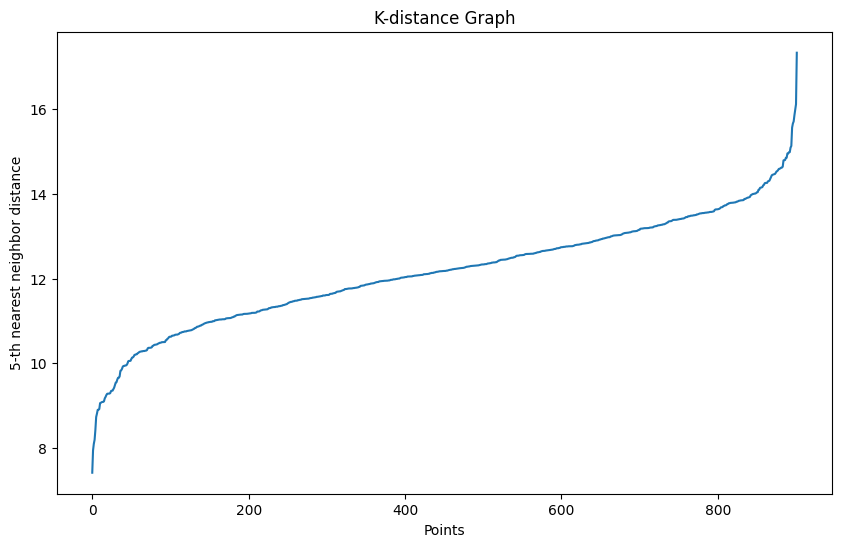

In [29]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(embeds)
distances, _ = neighbors.kneighbors(embeds)
distances = np.sort(distances[:, 4])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel(f'{5}-th nearest neighbor distance')
plt.title('K-distance Graph')
plt.show()

In [53]:
with open("out.txt", "w", encoding="utf-8") as f:
    for sent in sent_tokenize(longbench[5]["context"]):
        f.write(f"{sent}\n")


In [ ]:
testbench = longbench[5]
# print(testbench["question"])
with open("out.txt", "w", encoding="utf-8") as f:
    i = 0
    for chunk in chunkify_nltk(testbench["context"]):
        f.write(f"-----Chunk {i+1}-----\n{chunk}\n")
        i += 1
        if i >= 1: break

In [73]:
response = None
for bench in allWithQuality([("difficulty", "easy"), ("length", "short")]):
    # print(bench["question"])
    # print("".join((f"{c}: {bench[f"choice_{c}"]}\n" for c in ["A", "B", "C", "D"])))
    # print(bench["answer"])
    prompt = f"You will be provided long context, and then a multiple choice question. Please attempt to choose the correct answer:\n"
    prompt += f"CONTEXT: {bench["context"]}\n"
    prompt += f"QUESTION: {bench["question"]}\n"
    prompt += ("".join((f"{c}: {bench[f"choice_{c}"]}\n" for c in ["A", "B", "C", "D"])))
    response = gemini(prompt)
    print(response.text)
    break



The question asks how to promote the construction of smart courts. Let's examine the provided text for information related to "smart courts" or "intelligent courts."

Section XI. "Advancing the Construction of Intelligent Courts" directly addresses this topic.
The introductory paragraph states: "Since 2013, the people’s courts have conscientiously implemented the innovation-driven strategy, the national cyber development strategy, the big data strategy, and the new-generation artificial intelligence development plan, and comprehensively strengthened the construction of intelligent courts. The open, and intelligent online Apps have been comprehensively developed, and the main framework of court informatization version 3.0 has been established, which greatly promotes the modernization of the judicial system and judicial capability."

Let's analyze the options:

*   **A: Through technology empowerment, change the way of working and improve office efficiency.** This aligns with the general

In [37]:
with open("out.txt", "w", encoding="utf-8") as f:
    f.write(testbench["context"])

In [12]:
import numpy as np
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer

phrase_list = [ 'play an active role', 'participate actively', 'active lifestyle', "sleepy lifestyle", "active tag", "activate"]

model = SentenceTransformer('whaleloops/phrase-bert')
phrase_embs = model.encode( phrase_list )

In [13]:
for phrase1, emb1 in zip(phrase_list, phrase_embs):
    print(f"----{phrase1}----")
    for phrase2, emb2 in zip(phrase_list, phrase_embs):
        if phrase1 == phrase2: continue
        print(f"{np.linalg.norm(emb1 - emb2)} from '{phrase2}'")


----play an active role----
9.986579895019531 from 'participate actively'
14.458951950073242 from 'active lifestyle'
18.864044189453125 from 'sleepy lifestyle'
15.575200080871582 from 'active tag'
15.343635559082031 from 'activate'
----participate actively----
9.986579895019531 from 'play an active role'
15.094796180725098 from 'active lifestyle'
18.818584442138672 from 'sleepy lifestyle'
17.099464416503906 from 'active tag'
14.40995979309082 from 'activate'
----active lifestyle----
14.458951950073242 from 'play an active role'
15.094796180725098 from 'participate actively'
11.229645729064941 from 'sleepy lifestyle'
15.121877670288086 from 'active tag'
18.791048049926758 from 'activate'
----sleepy lifestyle----
18.864044189453125 from 'play an active role'
18.818584442138672 from 'participate actively'
11.229645729064941 from 'active lifestyle'
17.17343521118164 from 'active tag'
20.367082595825195 from 'activate'
----active tag----
15.575200080871582 from 'play an active role'
17.0994